# Arm Angles

This notebook serves as a way to estimate the arm angle of a pitcher using Baseball Savant pitch-by-pitch data. The methodology used comes from this article from Logan Mottely posted on [RundownBaseball.com](https://web.archive.org/web/20230123183755/https://www.rundownbaseball.com/project/calculating-arm-angles-using-statcast-data/). 

It uses the player height, release_pos_x, release_pos_y, and release_pos_z to form a triangle and calculate the angle of the hypotenuse (which is the arm angle).

## Import Packages

In [89]:
from highlight_text import fig_text, ax_text
import pandas as pd
import numpy as np
import pybaseball as pyb
import datetime as dt
import requests
import statsapi


## Retrieve Player Info from MLBStatsAPI

In [90]:
def fetch_team_data():
    """Fetches MLB team data from the API."""
    url = 'https://statsapi.mlb.com/api/v1/teams?sportId=1'
    try:
        response = requests.get(url)
        teams = response.json()
        team_df = pd.DataFrame(teams['teams'])
        team_df = team_df[['id', 'name', 'teamCode', 'fileCode', 'abbreviation', 'locationName', 'shortName']]
        return team_df
    except Exception as e:
        print(f"Failed to fetch team data: {e}")
        return pd.DataFrame()

def fetch_roster(team_id, season):
    """Fetches the roster for a team for a given season."""
    try:
        response = statsapi.get("team_roster", {
            "teamId": team_id,
            "rosterType": "fullRoster",
            "season": season,
            "hydrate": "person"
        })
        return response['roster']
    except KeyError:
        return []
    
def convert_height_to_inches(height_str):
    """Converts height from feet and inches to inches."""
    try:
        feet, inches = height_str.split("'")
        return int(feet.strip()) * 12 + int(inches.replace('"', '').strip())
    except (ValueError, AttributeError):
        return None

def process_player_info(roster, season, team_id):
    """Processes player data from roster."""
    player_data = []
    for player in roster:
        person = player['person']
        person['primaryPosition'] = person['primaryPosition']['abbreviation']
        person['batSide'] = person['batSide']['code']
        person['pitchHand'] = person['pitchHand']['code']
        person['season'] = season
        person['teamId'] = team_id
        player_data.append(person)
    return player_data

def build_player_info_df():
    teams = fetch_team_data()
    if teams.empty:
        print("No team data available.")
        return
    player_info = pd.DataFrame()
    
    for season in ['2024']:
        for team_id in teams['id']:
            roster = fetch_roster(team_id, season)
            player_data = process_player_info(roster, season, team_id)
            player_info = pd.concat([player_info, pd.DataFrame(player_data)], ignore_index=True)

    player_info['height'] = player_info['height'].apply(convert_height_to_inches)
    player_info = player_info[['id', 'fullName', 'height', 'weight', 'teamId']].drop_duplicates()
    player_info.to_csv('data/playerInfo.csv', index=False)
    print('Data collection complete. Results saved to file.')
    return player_info

In [91]:
player_info = build_player_info_df()
player_info.head()

Data collection complete. Results saved to file.


,id,fullName,height,weight,teamId
0,605156,Aaron Brooks,76.0,230.0,133
1,647351,Abraham Toro,72.0,223.0,133
2,661309,Adrián Martínez,74.0,215.0,133
3,683548,Adriel Gonzalez,74.0,145.0,133
4,649557,Aledmys Díaz,73.0,195.0,133


## Calculate Arm Angles

In [92]:
# Merge the Pitcher Info w/ Height from MLBStatsAPI
def merge_pitcher_info(df):
    pitcher_info = pd.read_csv('data/playerInfo.csv', usecols=['id', 'fullName', 'height'])
    pitcher_info.rename(columns={'fullName': 'pitcher_name',
                                'id': 'pitcher'}, inplace=True)
    
    pitcher_info = pitcher_info.drop_duplicates(subset='pitcher')
    return df.merge(pitcher_info, left_on='pitcher', right_on='pitcher', how='left')

# Calculate the Arm Angle from Baseball Savant data
def calculate_arm_angles(df):
    df['release_pos_x'] = df['release_pos_x'] * 12
    df['release_pos_z'] = df['release_pos_z'] * 12
    df['shoulder_pos'] = df['height'] * 0.70 # Calculate the shoulder position based on height
    df['Adj'] = df['release_pos_z'] - df['shoulder_pos'] # Adjacent side length
    df['Opp'] = abs(df['release_pos_x']) # Calculate the opposite side length
    df['arm_angle_rad'] = np.arctan2(df['Opp'], df['Adj']) # Calculate the arm angle in radians
    df['arm_angle'] = np.degrees(df['arm_angle_rad']) # Convert the arm angle to degrees
    df.drop(['Opp', 'arm_angle_rad'], axis=1, inplace=True)

    return df

def arm_angle_categories(df):
    bins = [0, 30, 60, 90, 120, 180]
    labels = ['Overhand', 'High Three-Quarters', 'Low Three-Quarters', 'Sidearm', 'Submarine']
    df['arm_angle_type'] = pd.cut(df['arm_angle'], bins=bins, labels=labels, right=False)

    return df

### Calculate Pitch Level Arm Angles

In [93]:
# Enable pybaseball cache
pyb.cache.enable()
data = pyb.statcast(start_dt='2024-01-01', end_dt='2024-12-31')

data = data[data['game_type'] == 'R']
data = merge_pitcher_info(data)
data = calculate_arm_angles(data)
data = arm_angle_categories(data)
data[['pitcher', 'pitcher_name', 'arm_angle', 'arm_angle_type']].head()

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [01:21<00:00,  3.01it/s]
/opt/homebrew/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


,pitcher,pitcher_name,arm_angle,arm_angle_type
0,592155,Cam Booser,61.285686,Low Three-Quarters
1,592155,Cam Booser,65.933543,Low Three-Quarters
2,592155,Cam Booser,58.036507,High Three-Quarters
3,592155,Cam Booser,60.194424,Low Three-Quarters
4,592155,Cam Booser,59.617991,High Three-Quarters


### Group by Pitcher

In [94]:
# Group By Pitcher
pitcher_data = data.groupby(['pitcher', 'pitcher_name', 'p_throws']).agg({'height': 'mean',
                                                                          'shoulder_pos': 'mean',
                                                                          'release_pos_x': 'mean',
                                                                          'release_pos_z': 'mean',
                                                                          'arm_angle': 'mean',
                                                                          }).reset_index()
pitcher_data = arm_angle_categories(pitcher_data)
pitcher_data.to_csv('data/overallArmAngles.csv', index=False)
pitcher_data.head(10)

,pitcher,pitcher_name,p_throws,height,shoulder_pos,release_pos_x,release_pos_z,arm_angle,arm_angle_type
0,434378,Justin Verlander,R,77.0,53.9,-18.605239,85.151726,30.683334,High Three-Quarters
1,445276,Kenley Jansen,R,77.0,53.9,-25.255575,77.033982,47.398249,High Three-Quarters
2,445926,Jesse Chavez,R,73.0,51.1,-19.203907,61.68586,61.068203,Low Three-Quarters
3,450203,Charlie Morton,R,77.0,53.9,-28.209073,66.229091,66.390007,Low Three-Quarters
4,455119,Chris Martin,R,80.0,56.0,-35.591299,72.784675,64.684428,Low Three-Quarters
5,458677,Justin Wilson,L,74.0,51.8,17.321558,76.246234,34.981121,High Three-Quarters
6,458681,Lance Lynn,R,77.0,53.9,-39.129749,67.222195,71.081061,Low Three-Quarters
7,471911,Carlos Carrasco,R,76.0,53.2,-16.604861,70.837917,43.186336,High Three-Quarters
8,472610,Luis García,R,74.0,51.8,-27.285676,75.287838,49.22294,High Three-Quarters
9,489119,Wade Miley,L,73.0,51.1,22.749153,74.842373,43.744578,High Three-Quarters


### Group by Pitcher and Pitch Type

In [95]:
# Group the data by pitcher & pitch type 
arsenal_arm_angles = data.groupby(['pitcher', 'pitcher_name', 'p_throws', 'pitch_type']).agg({'height': 'mean',
                                                                                              'shoulder_pos': 'mean',
                                                                                              'release_pos_x': 'mean',
                                                                                              'release_pos_z': 'mean',
                                                                                              'arm_angle': 'mean',
                                                                                              }).reset_index()

arsenal_arm_angles = arm_angle_categories(arsenal_arm_angles)
arsenal_arm_angles.head(10)


,pitcher,pitcher_name,p_throws,pitch_type,height,shoulder_pos,release_pos_x,release_pos_z,arm_angle,arm_angle_type
0,434378,Justin Verlander,R,CH,77.0,53.9,-19.634483,85.33931,31.918061,High Three-Quarters
1,434378,Justin Verlander,R,CU,77.0,53.9,-20.022778,84.748333,32.912248,High Three-Quarters
2,434378,Justin Verlander,R,FF,77.0,53.9,-17.282773,85.472773,28.644333,Overhand
3,434378,Justin Verlander,R,SL,77.0,53.9,-19.882623,84.703607,32.769111,High Three-Quarters
4,445276,Kenley Jansen,R,FC,77.0,53.9,-25.436066,77.008525,47.651066,High Three-Quarters
5,445276,Kenley Jansen,R,SI,77.0,53.9,-21.465882,77.491765,42.251251,High Three-Quarters
6,445276,Kenley Jansen,R,SL,77.0,53.9,-25.807059,77.032941,48.009416,High Three-Quarters
7,445926,Jesse Chavez,R,CH,73.0,51.1,-19.369091,62.078182,60.436862,Low Three-Quarters
8,445926,Jesse Chavez,R,CU,73.0,51.1,-17.737143,64.2,53.513835,High Three-Quarters
9,445926,Jesse Chavez,R,FC,73.0,51.1,-20.009114,60.964557,63.739864,Low Three-Quarters


## Plot Arm Angles

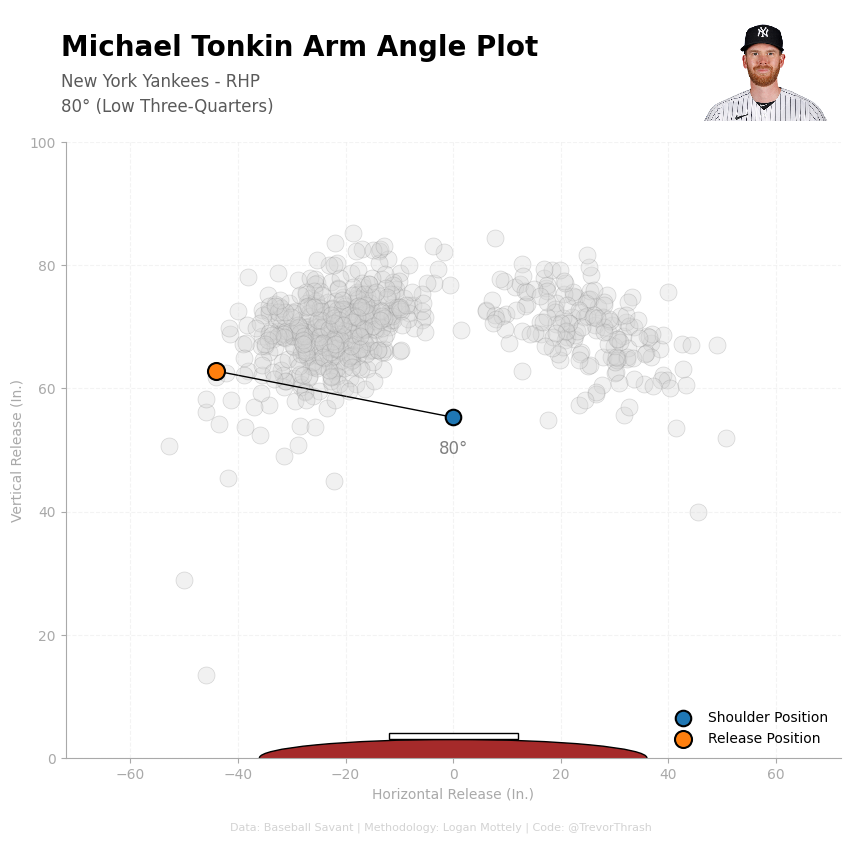

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Plot the arm angle for a pitcher
def plot_pitcher_arm_angle(pitcher_name, pitcher_data):
    pitcher = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]

    fig, ax = plt.subplots(figsize=(10, 8))
    x_values = np.zeros(len(pitcher['release_pos_x']))
    plt.scatter(x_values, pitcher['shoulder_pos'], s=125, lw=1.5, edgecolors='k', zorder=3, label='Shoulder Position')
    plt.scatter(pitcher['release_pos_x'], pitcher['release_pos_z'], s=150, lw=1.5, edgecolors='k', zorder=3, label='Release Position')

    # Draw a line between the shoulder and release point
    for i in range(len(pitcher)):
        plt.plot([0, pitcher['release_pos_x'].iloc[i]], [pitcher['shoulder_pos'].iloc[i], pitcher['release_pos_z'].iloc[i]], 'k-', lw=1, zorder=1)

    # Draw the mound as an ellipse
    mound = patches.Ellipse((0, 0), width=72, height=6, angle=0, facecolor='brown', edgecolor='black', linewidth=1, zorder=2)
    plt.gca().add_patch(mound)

    # Draw the rubber as a white rectangle with a black border
    rubber = patches.Rectangle((-12, 3), width=24, height=1, angle=0, edgecolor='black', facecolor='white', zorder=3)
    plt.gca().add_patch(rubber)
    
    # Plot the distribution of league release points
    plt.scatter(pitcher_data['release_pos_x'], pitcher_data['release_pos_z'], s=150, lw=0.5, edgecolors='gray', c='lightgray', alpha=0.3, zorder=0)

    # Format the arm angle as an integer
    arm_angle = int(pitcher['arm_angle'].iloc[0])
    arm_angle_type = pitcher['arm_angle_type'].iloc[0]
    p_throws = pitcher['p_throws'].iloc[0]

    # Get the current team name from MLBStatsAPI
    player_data = statsapi.lookup_player(f'{pitcher_name}')
    team_id = player_data[0]['currentTeam']['id']
    team_inf = statsapi.get('team', {'teamId': team_id})
    team_name = team_inf['teams'][0]['name']

    fig_text(
        x = 0.12, y = .98, 
        s = f"{pitcher_name} Arm Angle Plot",
        va = "bottom", ha = "left",
        fontsize = 20, color = "black", weight = "bold"
        )

    fig_text(
        x = 0.12, y = 0.9555, 
        s = f"{team_name} - {p_throws}HP",
        va = "center", ha = "left",
        fontsize = 12, color = "#5A5A5A",
        )
    
    fig_text(
        x = 0.12, y = 0.9125, 
        s = f"{arm_angle}° ({arm_angle_type})",
        va = "bottom", ha = "left",
        fontsize = 12, color = "#5A5A5A",
        )

    # Annotate the shoulder_pos with the words 'Shoulder Position'
    if pitcher['arm_angle'].iloc[0] > 90:
        ax_text(
        x = 0, y = pitcher['shoulder_pos'].mean() + 5, 
        s = f"{arm_angle}°",
        va = "center", ha = "center",
        fontsize = 12, color = "gray",
        )
    else:
        ax_text(
        x = 0, y = pitcher['shoulder_pos'].mean() - 5, 
        s = f"{arm_angle}°",
        va = "center", ha = "center",
        fontsize = 12, color = "gray",
        )
        

    fig_text(
        x = 0.5, y = 0.03, 
        s = f"Data: Baseball Savant | Methodology: Logan Mottely | Code: @TrevorThrash",
        va = "top", ha = "center",
        fontsize = 8, color = "lightgray",
    )

    try:
        img_path = f'player_img/{pitcher_name}.png'
        image = plt.imread(img_path)
        imagebox = OffsetImage(image, zoom=0.3)
        ab = AnnotationBbox(imagebox, (0.9, 1.12), frameon=False, xycoords='axes fraction', boxcoords="axes fraction")
        ax.add_artist(ab)
    except FileNotFoundError:
        pass

    ax.set_ylim(0, 100)
    ax.set_xlim(-72, 72)

    # Set tick color
    ax.tick_params(axis='x', colors='darkgray')
    ax.tick_params(axis='y', colors='darkgray')

    # Set axis label color
    ax.yaxis.label.set_color('darkgray')
    ax.xaxis.label.set_color('darkgray')
    
    ax.set_ylabel('Vertical Release (In.)')
    ax.set_xlabel('Horizontal Release (In.)')
    ax.grid(True, linestyle='--', alpha=0.25, color='lightgray')
    ax.legend(loc='lower right', frameon=False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('darkgray')
    plt.show()

plot_pitcher_arm_angle('Michael Tonkin', pitcher_data)

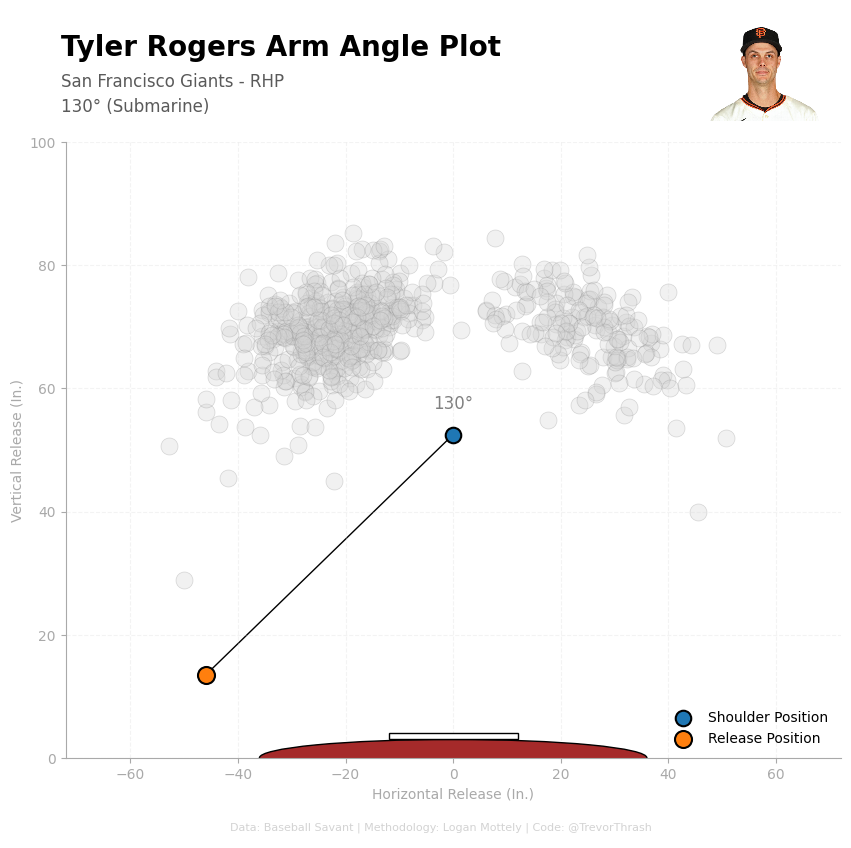

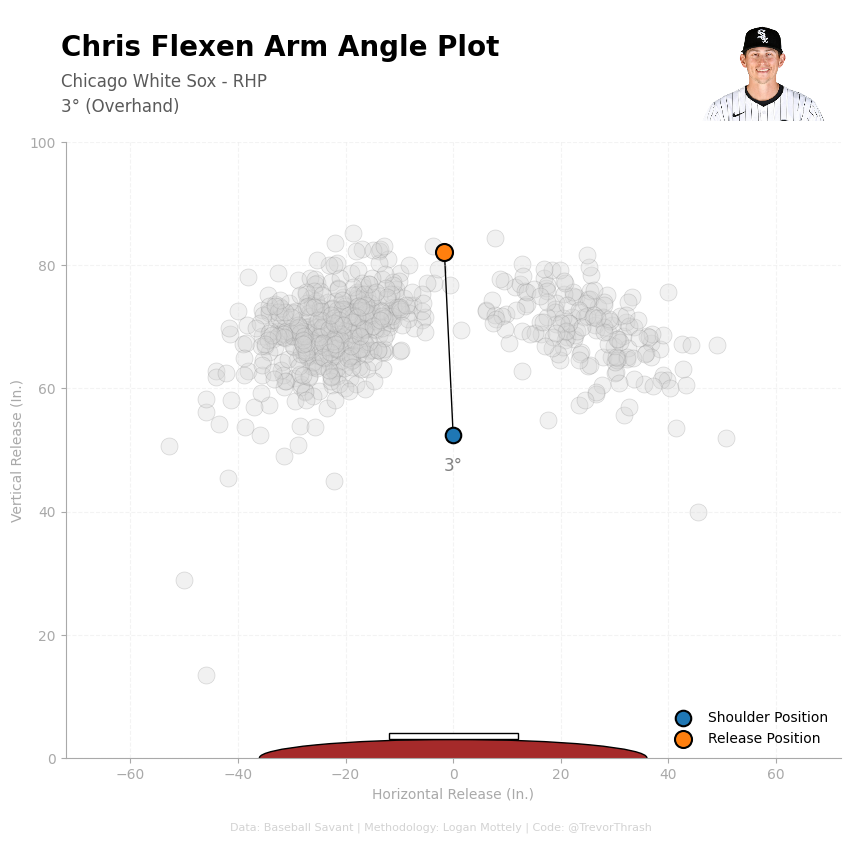

In [97]:
# Highest and lowest arm angle pitchers
highest_arm_angle = pitcher_data[pitcher_data['arm_angle'] == pitcher_data['arm_angle'].max()]
lowest_arm_angle = pitcher_data[pitcher_data['arm_angle'] == pitcher_data['arm_angle'].min()]

plot_pitcher_arm_angle(highest_arm_angle['pitcher_name'].iloc[0], pitcher_data)
plot_pitcher_arm_angle(lowest_arm_angle['pitcher_name'].iloc[0], pitcher_data)